In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os, glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from transformers import Dinov2Model



In [4]:
project_dir = '/Users/k.choi/Documents/github/csiro_git'
# project_dir = '/Users/kaheichoi/git_repo/csiro_biomass'
data_dir  = os.path.join(project_dir, 'data')
model_dir = os.path.join(project_dir, 'models')

train_csv = pd.read_csv(os.path.join(data_dir, 'train.csv'))
device    = torch.device('mps')

In [5]:
unique_paths  = train_csv['image_path'].unique(); print(unique_paths.shape)

(357,)


In [6]:
train_csv['target_name'].unique()

array(['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g',
       'GDM_g'], dtype=object)

In [7]:
def data_preprocess(df, data_dir):
    data_list = []
    
    unique_paths = df['image_path'].unique()
    target_names = df['target_name'].unique()

    for paths in unique_paths:
        data = df[ df['image_path'] == paths ]
        row = { 'image_path': paths }
        for tar in target_names:
            row[tar] = data[ data['target_name'] == tar ]['target'].values[0]
        
        data_list.append(row)

    return pd.DataFrame(data_list)

data_df = data_preprocess(train_csv, data_dir); display(data_df)


,image_path,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,train/ID1011485656.jpg,0.0000,31.9984,16.2751,48.2735,16.2750
1,train/ID1012260530.jpg,0.0000,0.0000,7.6000,7.6000,7.6000
2,train/ID1025234388.jpg,6.0500,0.0000,0.0000,6.0500,6.0500
3,train/ID1028611175.jpg,0.0000,30.9703,24.2376,55.2079,24.2376
4,train/ID1035947949.jpg,0.4343,23.2239,10.5261,34.1844,10.9605
...,...,...,...,...,...,...
352,train/ID975115267.jpg,40.0300,0.0000,0.8000,40.8300,40.8300
353,train/ID978026131.jpg,24.6445,4.1948,12.0601,40.8994,36.7046
354,train/ID980538882.jpg,0.0000,1.1457,91.6543,92.8000,91.6543
355,train/ID980878870.jpg,32.3575,0.0000,2.0325,34.3900,34.3900


In [8]:
train_data, test_data  = train_test_split(data_df, test_size=0.01, random_state=8964); print(f'train: {len(train_data)}, test: {len(test_data)}')

train: 353, test: 4


In [9]:
def create_stratified_folds(df, target_col='Dry_Total_g', n_folds=5, random_state=8964):
    strata_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
 
    bins = [0, 20, 40, 60, 80, np.inf]
    dfcopy = df.copy()
    dfcopy['strata'] = pd.cut(dfcopy[target_col], bins=bins, labels=False) 
    
    kfolds = []
    for train_idx, val_idx in strata_kfold.split(dfcopy, dfcopy['strata']):
        kfolds.append((train_idx, val_idx))
    
    return kfolds

kfolds  = create_stratified_folds(train_data, target_col='Dry_Total_g', n_folds=5)

for i, (train_idx, val_idx) in enumerate(kfolds): 
    print(f"Fold {i+1}: {len(train_idx)} train, {len(val_idx)} val")
    assert len(train_idx) + len(val_idx) == len(train_data)

Fold 1: 282 train, 71 val
Fold 2: 282 train, 71 val
Fold 3: 282 train, 71 val
Fold 4: 283 train, 70 val
Fold 5: 283 train, 70 val


In [10]:
class tta:

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std 

    def get_transforms(self):
        return [
            ( 'id',     self.__get_id()),
            ( 'hflip',  self.__get_hflip()),
            ( 'vflip',  self.__get_vflip()),
            ( 'rot90',  self.__get_rota(90)),
            ( 'rot180', self.__get_rota(180)),
            ( 'rot270', self.__get_rota(270)) ]

    def __get_id(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std) ])

    def __get_hflip(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomHorizontalFlip(p=1),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std) ])

    def __get_vflip(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomVerticalFlip(p=1),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std) ])
        
    def __get_rota(self,angle):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.Lambda(lambda img: transforms.functional.rotate(img, angle)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std) ])
         

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]  

tta_transforms = tta(mean=mean, std=std)
tta_list = tta_transforms.get_transforms()

for names, _ in tta_list: print(names)

id
hflip
vflip
rot90
rot180
rot270


In [11]:
class random_tranfo:

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def get_transfo(self):
        return [ self.train_transform(), self.valid_transform() ]
        
    ### no rota because no differences
    def train_transform(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])
    
    def valid_transform(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])
     

rand_transfo = random_tranfo(mean=mean, std=std)
train_transfo, valid_transfo = rand_transfo.get_transfo()


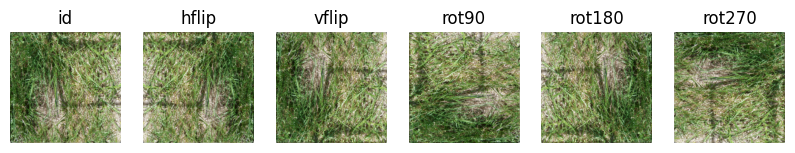

In [12]:
img_path = os.path.join( data_dir, np.random.choice(unique_paths)) 

fig,axes = plt.subplots(1,6, figsize=(10,3))
for i, (name, transform) in enumerate(tta_list):
    img = Image.open(img_path)
    img = transform(img)
    
    mean = torch.tensor( [0.485, 0.456, 0.406] ).view(3,1,1)
    std  = torch.tensor( [0.229, 0.224, 0.225] ).view(3,1,1)

    img  = img * std + mean
    img  = torch.clamp(img,0,1)
    img  = img.permute(1,2,0).numpy()

    axes[i].imshow(img)
    axes[i].set_title(name)
    axes[i].axis('off')

plt.show()

In [13]:
class BiomassDS(Dataset):
    def __init__(self, df, data_dir, transform, target_names = ['Dry_Clover_g','Dry_Dead_g', 'Dry_Green_g','Dry_Total_g','GDM_g']):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform
        self.target_names = target_names

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.data_dir, row['image_path'])
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        targets = torch.tensor([row[col] for col in self.target_names], dtype=torch.float32)
        return img, targets

In [14]:
# class TTABiomassDS(Dataset):
#     def __init__(self, df, data_dir, transform, target_names = ['Dry_Clover_g','Dry_Dead_g', 'Dry_Green_g','Dry_Total_g','GDM_g']):
#         self.df = df.reset_index(drop=True)
#         self.data_dir = data_dir
#         self.transform = transform
#         self.target_names = target_names

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         img = Image.open(os.path.join(self.data_dir, row['image_path'])).convert('RGB')


In [15]:
class call_my_dino(nn.Module):
    def __init__(self, backbone, patch_dim, n_targets):
        super().__init__()
        
        self.backbone = backbone
        for params in self.backbone.parameters():
            params.requires_grad = False

        self.dino_head = nn.Sequential(
            nn.Linear(patch_dim, 512),
            nn.LayerNorm(512),  
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),  
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(256, n_targets),
        )

    def forward(self, x):
        with torch.no_grad():
            outputs = self.backbone(x)
            patch_features = outputs.last_hidden_state[:, 1:, :]

        batch_size, n_patches, patch_dim = patch_features.shape
        patch_features_flat = patch_features.reshape(-1, patch_dim)
        patch_pred = self.dino_head(patch_features_flat)
        patch_pred = patch_pred.reshape(batch_size, n_patches, -1)

        final_pred = torch.mean(patch_pred, dim=1)

        return final_pred, patch_pred

In [16]:
small_dinov2_backbone = Dinov2Model.from_pretrained('facebook/dinov2-small');
small_dinov2_backbone.eval();
small_dinov2_backbone.to(device);

In [17]:
# dino_model = call_my_dino(small_dinov2_backbone, patch_dim=384, n_targets=5)

# dino_model.load_state_dict(torch.load(os.path.join(model_dir, 'dino_model_small.pth')))
# dino_model.to(device)
# dino_model.eval()

In [18]:
from sklearn.metrics import mean_squared_error

def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss , batch = 0 , 0 

    pbar = tqdm(train_loader, desc='Training')
    for img, tar in pbar:
        img, tar = img.to(device), tar.to(device)

        optimizer.zero_grad()
        pred, _ = model(img)
        loss = criterion(pred, tar)

        loss.backward(); optimizer.step()
        total_loss += loss.item(); batch += 1 
    return total_loss / batch

def valid_epoch(model, valid_loader, criterion, device):
    model.eval()
    total_loss , batch = 0 , 0 

    all_pred, all_tar = [], []
    with torch.no_grad():

        pbar = tqdm(valid_loader, desc='Validation')
        for img, tar in pbar:
            img, tar = img.to(device), tar.to(device)
            
            pred, _ = model(img)
            loss    = criterion(pred, tar)

            total_loss += loss.item(); batch += 1

            all_pred.append(pred.cpu()); all_tar.append(tar.cpu())

    all_pred = torch.cat(all_pred).numpy()
    all_tar  = torch.cat(all_tar).numpy()

    avg_loss = total_loss / batch
    rmse     = np.sqrt(mean_squared_error(all_pred, all_tar))

    return avg_loss, rmse

In [19]:
MAX_EPOCHS = 120

LR = 1e-3
WEIGHT_DECAY = 1e-4
LR_PATIENCE = 5
PATIENCE = 10

batch_size  = 16

criterion = nn.MSELoss()

fold_model, fold_history, fold_best_rmses = [], [], []


for fold_idx, (train_idx, val_idx) in enumerate(kfolds):

    train_fold = train_data.iloc[train_idx]
    valid_fold = train_data.iloc[val_idx]

    print(f'Fold {fold_idx+1} : {len(train_idx)} train, {len(val_idx)} val')

    train_ds     = BiomassDS(df =train_fold, data_dir =data_dir, transform = train_transfo)
    valid_ds     = BiomassDS(df =valid_fold, data_dir =data_dir, transform = valid_transfo)
    
    train_loader = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size= batch_size, shuffle=False)
 
    print('Dataloader completed')
    model = call_my_dino(small_dinov2_backbone, patch_dim=384, n_targets=5)
    model.to(device)

    print('Dino has been summoned')
 
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY) 
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience= LR_PATIENCE)
 
    print('Optimizer has arrived so as the scheduler')
    print(' ==' * 32)

    history = {'train_loss':[], 'valid_loss':[], 'rmse':[], 'learning_rate':[]}
    best_val, best_rmse, best_epoch, epoch_counter, best_model = np.inf,0,0,0, None

    for epoch in range(MAX_EPOCHS):

        print(f'Epoch {epoch+1} / {MAX_EPOCHS}')
        print(' -' * 32)
        epoch_counter += 1

        train_loss              = train_epoch(model, train_loader, optimizer, criterion, device)
        valid_loss, valid_rmse  = valid_epoch(model, valid_loader, criterion, device)
        
        scheduler.step(valid_loss)
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['rmse'].append(valid_rmse)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Train loss: {train_loss:.4f}, Valid loss: {valid_loss:.4f}, Valid RMSE: {valid_rmse:.4f}')
        if valid_loss < best_val:
            best_val  = valid_loss
            best_rmse = valid_rmse
            best_epoch = epoch
            best_model = model.state_dict()

            torch.save(best_model, os.path.join(model_dir, f'best_model_fold_{fold_idx}.pth'))
            epoch_counter = 0

            print(f'New best model at epoch {best_epoch} with val_loss {best_val}')
        else:
            print(f'no improvement since epoch {best_epoch} with val_loss {best_val}')
            epoch_counter += 1
        
        if epoch_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch_counter}, best model at epoch {best_epoch}')
            break

    fold_history.append(history) 
    fold_model.append(best_model) 
    fold_best_rmses.append(best_rmse)

    torch.mps.empty_cache()
    

Fold 1 : 282 train, 71 val
Dataloader completed
Dino has been summoned
Optimizer has arrived so as the scheduler
 == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == ==
Epoch 1 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Train loss: 1143.9093, Valid loss: 894.9844, Valid RMSE: 31.0566
New best model at epoch 0 with val_loss 894.9843872070312
Epoch 2 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Train loss: 1041.3785, Valid loss: 802.2088, Valid RMSE: 29.4425
New best model at epoch 1 with val_loss 802.2088256835938
Epoch 3 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Train loss: 929.0420, Valid loss: 717.3942, Valid RMSE: 27.8731
New best model at epoch 2 with val_loss 717.3941802978516
Epoch 4 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Train loss: 847.4754, Valid loss: 642.8276, Valid RMSE: 26.4016
New best model at epoch 3 with val_loss 642.8275848388672
Epoch 5 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Train loss: 773.6353, Valid loss: 582.1996, Valid RMSE: 25.1271
New best model at epoch 4 with val_loss 582.1995544433594
Epoch 6 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Train loss: 687.9253, Valid loss: 530.8348, Valid RMSE: 23.9812
New best model at epoch 5 with val_loss 530.8348358154296
Epoch 7 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Train loss: 621.0002, Valid loss: 484.5270, Valid RMSE: 22.9262
New best model at epoch 6 with val_loss 484.5270233154297
Epoch 8 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Train loss: 599.7651, Valid loss: 446.3606, Valid RMSE: 22.0193
New best model at epoch 7 with val_loss 446.3606384277344
Epoch 9 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 529.9318, Valid loss: 410.4470, Valid RMSE: 21.0840
New best model at epoch 8 with val_loss 410.44704284667966
Epoch 10 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Train loss: 483.4213, Valid loss: 380.2428, Valid RMSE: 20.2566
New best model at epoch 9 with val_loss 380.24281311035156
Epoch 11 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Train loss: 439.0578, Valid loss: 360.7948, Valid RMSE: 19.6707
New best model at epoch 10 with val_loss 360.7948272705078
Epoch 12 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Train loss: 414.1190, Valid loss: 341.8068, Valid RMSE: 19.1084
New best model at epoch 11 with val_loss 341.8067993164062
Epoch 13 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Train loss: 383.6751, Valid loss: 312.0689, Valid RMSE: 18.2023
New best model at epoch 12 with val_loss 312.0688934326172
Epoch 14 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Train loss: 354.1607, Valid loss: 295.5487, Valid RMSE: 17.6737
New best model at epoch 13 with val_loss 295.5487487792969
Epoch 15 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Train loss: 335.1778, Valid loss: 284.3622, Valid RMSE: 17.2112
New best model at epoch 14 with val_loss 284.36220397949216
Epoch 16 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 315.5815, Valid loss: 263.7092, Valid RMSE: 16.6706
New best model at epoch 15 with val_loss 263.70924682617186
Epoch 17 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Train loss: 293.4984, Valid loss: 256.0540, Valid RMSE: 16.3191
New best model at epoch 16 with val_loss 256.0540496826172
Epoch 18 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train loss: 275.0755, Valid loss: 242.1322, Valid RMSE: 15.8250
New best model at epoch 17 with val_loss 242.1322479248047
Epoch 19 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Train loss: 252.7133, Valid loss: 229.9216, Valid RMSE: 15.3720
New best model at epoch 18 with val_loss 229.92157897949218
Epoch 20 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 242.5450, Valid loss: 226.0590, Valid RMSE: 15.1662
New best model at epoch 19 with val_loss 226.0590087890625
Epoch 21 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 223.6317, Valid loss: 216.2367, Valid RMSE: 14.8488
New best model at epoch 20 with val_loss 216.23673400878906
Epoch 22 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Train loss: 215.6683, Valid loss: 201.4694, Valid RMSE: 14.2726
New best model at epoch 21 with val_loss 201.4694381713867
Epoch 23 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 202.4152, Valid loss: 190.4612, Valid RMSE: 13.9514
New best model at epoch 22 with val_loss 190.46121520996093
Epoch 24 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Train loss: 187.6887, Valid loss: 188.1267, Valid RMSE: 13.8065
New best model at epoch 23 with val_loss 188.12665100097655
Epoch 25 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 193.3994, Valid loss: 186.7511, Valid RMSE: 13.7200
New best model at epoch 24 with val_loss 186.7510528564453
Epoch 26 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 167.6648, Valid loss: 173.9267, Valid RMSE: 13.2413
New best model at epoch 25 with val_loss 173.92666473388672
Epoch 27 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Train loss: 159.2165, Valid loss: 178.9247, Valid RMSE: 13.3317
no improvement since epoch 25 with val_loss 173.92666473388672
Epoch 28 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Train loss: 151.2407, Valid loss: 164.1877, Valid RMSE: 12.8302
New best model at epoch 27 with val_loss 164.18773040771484
Epoch 29 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 142.6701, Valid loss: 168.9681, Valid RMSE: 12.9803
no improvement since epoch 27 with val_loss 164.18773040771484
Epoch 30 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 143.1968, Valid loss: 156.6658, Valid RMSE: 12.4334
New best model at epoch 29 with val_loss 156.6657684326172
Epoch 31 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 135.9126, Valid loss: 159.5839, Valid RMSE: 12.5413
no improvement since epoch 29 with val_loss 156.6657684326172
Epoch 32 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Train loss: 122.4256, Valid loss: 149.1264, Valid RMSE: 12.1708
New best model at epoch 31 with val_loss 149.12635040283203
Epoch 33 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Train loss: 116.7927, Valid loss: 146.7002, Valid RMSE: 11.9412
New best model at epoch 32 with val_loss 146.70023345947266
Epoch 34 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Train loss: 112.1514, Valid loss: 152.0832, Valid RMSE: 12.2426
no improvement since epoch 32 with val_loss 146.70023345947266
Epoch 35 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Train loss: 103.4919, Valid loss: 149.1038, Valid RMSE: 11.9587
no improvement since epoch 32 with val_loss 146.70023345947266
Epoch 36 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Train loss: 99.8345, Valid loss: 146.2656, Valid RMSE: 11.9582
New best model at epoch 35 with val_loss 146.26563873291016
Epoch 37 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 96.9705, Valid loss: 154.3504, Valid RMSE: 12.0914
no improvement since epoch 35 with val_loss 146.26563873291016
Epoch 38 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Train loss: 99.6808, Valid loss: 151.4444, Valid RMSE: 12.0649
no improvement since epoch 35 with val_loss 146.26563873291016
Epoch 39 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Train loss: 88.8665, Valid loss: 154.5757, Valid RMSE: 12.2593
no improvement since epoch 35 with val_loss 146.26563873291016
Epoch 40 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Train loss: 84.5153, Valid loss: 139.9980, Valid RMSE: 11.5998
New best model at epoch 39 with val_loss 139.9980438232422
Epoch 41 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 78.3310, Valid loss: 140.0482, Valid RMSE: 11.5196
no improvement since epoch 39 with val_loss 139.9980438232422
Epoch 42 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 71.2224, Valid loss: 137.9550, Valid RMSE: 11.5434
New best model at epoch 41 with val_loss 137.95495147705077
Epoch 43 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Train loss: 70.4910, Valid loss: 136.6333, Valid RMSE: 11.4761
New best model at epoch 42 with val_loss 136.6333023071289
Epoch 44 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Train loss: 68.0371, Valid loss: 153.7371, Valid RMSE: 12.1296
no improvement since epoch 42 with val_loss 136.6333023071289
Epoch 45 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Train loss: 70.7515, Valid loss: 130.4257, Valid RMSE: 11.2192
New best model at epoch 44 with val_loss 130.42573623657228
Epoch 46 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Train loss: 63.2618, Valid loss: 141.1993, Valid RMSE: 11.5649
no improvement since epoch 44 with val_loss 130.42573623657228
Epoch 47 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Train loss: 60.9297, Valid loss: 135.0774, Valid RMSE: 11.3218
no improvement since epoch 44 with val_loss 130.42573623657228
Epoch 48 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Train loss: 55.8938, Valid loss: 144.0239, Valid RMSE: 11.6574
no improvement since epoch 44 with val_loss 130.42573623657228
Epoch 49 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Train loss: 52.3617, Valid loss: 143.5159, Valid RMSE: 11.6136
no improvement since epoch 44 with val_loss 130.42573623657228
Epoch 50 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train loss: 51.5197, Valid loss: 135.7178, Valid RMSE: 11.4013
no improvement since epoch 44 with val_loss 130.42573623657228
Early stopping at epoch 10, best model at epoch 44
Fold 2 : 282 train, 71 val
Dataloader completed
Dino has been summoned
Optimizer has arrived so as the scheduler
 == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == ==
Epoch 1 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Train loss: 1079.2641, Valid loss: 1217.5149, Valid RMSE: 35.5420
New best model at epoch 0 with val_loss 1217.5148803710938
Epoch 2 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Train loss: 950.9823, Valid loss: 1108.3889, Valid RMSE: 33.9573
New best model at epoch 1 with val_loss 1108.388916015625
Epoch 3 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Train loss: 849.9398, Valid loss: 1006.1675, Valid RMSE: 32.4007
New best model at epoch 2 with val_loss 1006.1674560546875
Epoch 4 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Train loss: 762.2755, Valid loss: 915.3998, Valid RMSE: 30.9505
New best model at epoch 3 with val_loss 915.3998107910156
Epoch 5 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Train loss: 687.7556, Valid loss: 835.3039, Valid RMSE: 29.6084
New best model at epoch 4 with val_loss 835.3039245605469
Epoch 6 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Train loss: 616.2056, Valid loss: 768.2341, Valid RMSE: 28.4324
New best model at epoch 5 with val_loss 768.2340759277344
Epoch 7 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Train loss: 568.7219, Valid loss: 712.8186, Valid RMSE: 27.4168
New best model at epoch 6 with val_loss 712.8186218261719
Epoch 8 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 529.6594, Valid loss: 654.8557, Valid RMSE: 26.3153
New best model at epoch 7 with val_loss 654.8556579589844
Epoch 9 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 473.7690, Valid loss: 608.6178, Valid RMSE: 25.4017
New best model at epoch 8 with val_loss 608.6177764892578
Epoch 10 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Train loss: 429.8539, Valid loss: 562.6287, Valid RMSE: 24.4764
New best model at epoch 9 with val_loss 562.6287017822266
Epoch 11 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train loss: 396.9162, Valid loss: 534.0260, Valid RMSE: 23.8667
New best model at epoch 10 with val_loss 534.0259826660156
Epoch 12 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Train loss: 376.5472, Valid loss: 493.2165, Valid RMSE: 22.9715
New best model at epoch 11 with val_loss 493.2164764404297
Epoch 13 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train loss: 347.9515, Valid loss: 467.4098, Valid RMSE: 22.3694
New best model at epoch 12 with val_loss 467.4097839355469
Epoch 14 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Train loss: 314.7081, Valid loss: 435.9264, Valid RMSE: 21.6279
New best model at epoch 13 with val_loss 435.9263717651367
Epoch 15 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 291.8835, Valid loss: 414.2906, Valid RMSE: 21.0936
New best model at epoch 14 with val_loss 414.2906036376953
Epoch 16 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Train loss: 265.2623, Valid loss: 393.3373, Valid RMSE: 20.5557
New best model at epoch 15 with val_loss 393.3373336791992
Epoch 17 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 250.6115, Valid loss: 381.2425, Valid RMSE: 20.2438
New best model at epoch 16 with val_loss 381.2425308227539
Epoch 18 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Train loss: 237.9862, Valid loss: 361.1376, Valid RMSE: 19.6819
New best model at epoch 17 with val_loss 361.13759460449216
Epoch 19 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Train loss: 219.3073, Valid loss: 345.3737, Valid RMSE: 19.2993
New best model at epoch 18 with val_loss 345.3737426757813
Epoch 20 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Train loss: 200.1475, Valid loss: 339.9312, Valid RMSE: 19.1646
New best model at epoch 19 with val_loss 339.9312469482422
Epoch 21 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Train loss: 196.6152, Valid loss: 322.0227, Valid RMSE: 18.6590
New best model at epoch 20 with val_loss 322.02270050048827
Epoch 22 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Train loss: 174.6436, Valid loss: 312.5069, Valid RMSE: 18.3663
New best model at epoch 21 with val_loss 312.50689086914065
Epoch 23 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Train loss: 166.0507, Valid loss: 302.8334, Valid RMSE: 18.0992
New best model at epoch 22 with val_loss 302.8334136962891
Epoch 24 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Train loss: 153.3333, Valid loss: 294.4013, Valid RMSE: 17.8146
New best model at epoch 23 with val_loss 294.40125579833983
Epoch 25 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 152.2027, Valid loss: 287.8230, Valid RMSE: 17.6287
New best model at epoch 24 with val_loss 287.8230209350586
Epoch 26 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Train loss: 133.2878, Valid loss: 305.1138, Valid RMSE: 18.1273
no improvement since epoch 24 with val_loss 287.8230209350586
Epoch 27 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Train loss: 130.1719, Valid loss: 276.7668, Valid RMSE: 17.2518
New best model at epoch 26 with val_loss 276.7668395996094
Epoch 28 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 123.1074, Valid loss: 263.0534, Valid RMSE: 16.8332
New best model at epoch 27 with val_loss 263.0534072875977
Epoch 29 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Train loss: 118.3623, Valid loss: 269.7610, Valid RMSE: 16.9780
no improvement since epoch 27 with val_loss 263.0534072875977
Epoch 30 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Train loss: 119.9664, Valid loss: 264.7897, Valid RMSE: 16.8073
no improvement since epoch 27 with val_loss 263.0534072875977
Epoch 31 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Train loss: 104.2285, Valid loss: 259.4071, Valid RMSE: 16.6716
New best model at epoch 30 with val_loss 259.40711822509763
Epoch 32 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 97.6715, Valid loss: 247.3927, Valid RMSE: 16.2801
New best model at epoch 31 with val_loss 247.3927200317383
Epoch 33 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 90.2122, Valid loss: 249.5140, Valid RMSE: 16.3491
no improvement since epoch 31 with val_loss 247.3927200317383
Epoch 34 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Train loss: 84.6515, Valid loss: 238.6093, Valid RMSE: 15.9504
New best model at epoch 33 with val_loss 238.6092956542969
Epoch 35 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Train loss: 79.5944, Valid loss: 239.8469, Valid RMSE: 16.0162
no improvement since epoch 33 with val_loss 238.6092956542969
Epoch 36 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Train loss: 74.7296, Valid loss: 225.7295, Valid RMSE: 15.4751
New best model at epoch 35 with val_loss 225.7295364379883
Epoch 37 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Train loss: 72.7844, Valid loss: 236.5855, Valid RMSE: 15.8019
no improvement since epoch 35 with val_loss 225.7295364379883
Epoch 38 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Train loss: 71.6117, Valid loss: 227.4472, Valid RMSE: 15.6079
no improvement since epoch 35 with val_loss 225.7295364379883
Epoch 39 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Train loss: 70.3934, Valid loss: 228.5676, Valid RMSE: 15.5990
no improvement since epoch 35 with val_loss 225.7295364379883
Epoch 40 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Train loss: 69.0709, Valid loss: 218.3072, Valid RMSE: 15.2601
New best model at epoch 39 with val_loss 218.30721435546874
Epoch 41 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Train loss: 68.9541, Valid loss: 216.0668, Valid RMSE: 15.1864
New best model at epoch 40 with val_loss 216.06682739257812
Epoch 42 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Train loss: 57.7813, Valid loss: 220.5776, Valid RMSE: 15.3317
no improvement since epoch 40 with val_loss 216.06682739257812
Epoch 43 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Train loss: 57.3833, Valid loss: 210.8007, Valid RMSE: 14.9956
New best model at epoch 42 with val_loss 210.8006851196289
Epoch 44 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Train loss: 56.7282, Valid loss: 208.0398, Valid RMSE: 14.9167
New best model at epoch 43 with val_loss 208.0397705078125
Epoch 45 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Train loss: 52.8801, Valid loss: 229.5266, Valid RMSE: 15.6360
no improvement since epoch 43 with val_loss 208.0397705078125
Epoch 46 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Train loss: 50.0482, Valid loss: 202.4126, Valid RMSE: 14.7600
New best model at epoch 45 with val_loss 202.41260833740233
Epoch 47 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Train loss: 47.1639, Valid loss: 204.1200, Valid RMSE: 14.7485
no improvement since epoch 45 with val_loss 202.41260833740233
Epoch 48 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Train loss: 44.3941, Valid loss: 198.5169, Valid RMSE: 14.5600
New best model at epoch 47 with val_loss 198.5168701171875
Epoch 49 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Train loss: 42.5647, Valid loss: 187.0186, Valid RMSE: 14.1080
New best model at epoch 48 with val_loss 187.01858367919922
Epoch 50 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train loss: 39.2288, Valid loss: 205.5582, Valid RMSE: 14.8037
no improvement since epoch 48 with val_loss 187.01858367919922
Epoch 51 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Train loss: 44.1972, Valid loss: 200.3554, Valid RMSE: 14.6592
no improvement since epoch 48 with val_loss 187.01858367919922
Epoch 52 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 41.0384, Valid loss: 201.9160, Valid RMSE: 14.6504
no improvement since epoch 48 with val_loss 187.01858367919922
Epoch 53 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Train loss: 38.6433, Valid loss: 190.9393, Valid RMSE: 14.3575
no improvement since epoch 48 with val_loss 187.01858367919922
Epoch 54 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 37.4839, Valid loss: 186.3690, Valid RMSE: 14.1445
New best model at epoch 53 with val_loss 186.36896820068358
Epoch 55 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 33.3455, Valid loss: 186.9256, Valid RMSE: 14.1544
no improvement since epoch 53 with val_loss 186.36896820068358
Epoch 56 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Train loss: 32.5677, Valid loss: 190.8065, Valid RMSE: 14.2732
no improvement since epoch 53 with val_loss 186.36896820068358
Epoch 57 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 30.6048, Valid loss: 182.6293, Valid RMSE: 14.0092
New best model at epoch 56 with val_loss 182.6293472290039
Epoch 58 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 29.5497, Valid loss: 193.5861, Valid RMSE: 14.3813
no improvement since epoch 56 with val_loss 182.6293472290039
Epoch 59 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 29.3920, Valid loss: 184.2238, Valid RMSE: 14.0755
no improvement since epoch 56 with val_loss 182.6293472290039
Epoch 60 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 26.0926, Valid loss: 185.5401, Valid RMSE: 14.1214
no improvement since epoch 56 with val_loss 182.6293472290039
Epoch 61 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 26.5221, Valid loss: 182.4354, Valid RMSE: 13.9925
New best model at epoch 60 with val_loss 182.4354461669922
Epoch 62 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 25.7252, Valid loss: 165.2324, Valid RMSE: 13.3201
New best model at epoch 61 with val_loss 165.2324188232422
Epoch 63 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 24.9861, Valid loss: 182.9216, Valid RMSE: 14.0345
no improvement since epoch 61 with val_loss 165.2324188232422
Epoch 64 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 21.8886, Valid loss: 174.5908, Valid RMSE: 13.7574
no improvement since epoch 61 with val_loss 165.2324188232422
Epoch 65 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 24.0403, Valid loss: 201.0706, Valid RMSE: 14.6232
no improvement since epoch 61 with val_loss 165.2324188232422
Epoch 66 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 26.2728, Valid loss: 199.1616, Valid RMSE: 14.5315
no improvement since epoch 61 with val_loss 165.2324188232422
Epoch 67 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 24.4955, Valid loss: 192.4799, Valid RMSE: 14.4006
no improvement since epoch 61 with val_loss 165.2324188232422
Early stopping at epoch 10, best model at epoch 61
Fold 3 : 282 train, 71 val
Dataloader completed
Dino has been summoned
Optimizer has arrived so as the scheduler
 == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == ==
Epoch 1 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Train loss: 1113.7720, Valid loss: 1312.0505, Valid RMSE: 33.2327
New best model at epoch 0 with val_loss 1312.0504760742188
Epoch 2 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Train loss: 1004.5957, Valid loss: 1192.2076, Valid RMSE: 31.5493
New best model at epoch 1 with val_loss 1192.2076416015625
Epoch 3 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Train loss: 888.1019, Valid loss: 1079.2109, Valid RMSE: 29.8948
New best model at epoch 2 with val_loss 1079.2108764648438
Epoch 4 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Train loss: 799.5932, Valid loss: 980.5808, Valid RMSE: 28.3908
New best model at epoch 3 with val_loss 980.5808227539062
Epoch 5 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Train loss: 721.1585, Valid loss: 892.8570, Valid RMSE: 27.0032
New best model at epoch 4 with val_loss 892.8570434570313
Epoch 6 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Train loss: 667.6232, Valid loss: 819.2103, Valid RMSE: 25.7943
New best model at epoch 5 with val_loss 819.2103149414063
Epoch 7 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Train loss: 610.2963, Valid loss: 748.7420, Valid RMSE: 24.5814
New best model at epoch 6 with val_loss 748.742041015625
Epoch 8 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Train loss: 550.1775, Valid loss: 685.6052, Valid RMSE: 23.4582
New best model at epoch 7 with val_loss 685.6052368164062
Epoch 9 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Train loss: 534.8870, Valid loss: 632.8372, Valid RMSE: 22.4847
New best model at epoch 8 with val_loss 632.8372253417969
Epoch 10 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train loss: 464.7433, Valid loss: 582.2692, Valid RMSE: 21.5331
New best model at epoch 9 with val_loss 582.2691955566406
Epoch 11 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train loss: 434.1845, Valid loss: 544.0160, Valid RMSE: 20.7863
New best model at epoch 10 with val_loss 544.0159912109375
Epoch 12 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Train loss: 402.3849, Valid loss: 512.8526, Valid RMSE: 20.2022
New best model at epoch 11 with val_loss 512.8526092529297
Epoch 13 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Train loss: 374.6054, Valid loss: 469.2748, Valid RMSE: 19.2399
New best model at epoch 12 with val_loss 469.27475891113284
Epoch 14 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Train loss: 355.8665, Valid loss: 437.6960, Valid RMSE: 18.5470
New best model at epoch 13 with val_loss 437.6959655761719
Epoch 15 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Train loss: 328.6411, Valid loss: 415.5426, Valid RMSE: 18.1255
New best model at epoch 14 with val_loss 415.54261779785156
Epoch 16 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Train loss: 324.5111, Valid loss: 398.4845, Valid RMSE: 17.7857
New best model at epoch 15 with val_loss 398.4844665527344
Epoch 17 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Train loss: 283.3610, Valid loss: 369.2595, Valid RMSE: 17.0661
New best model at epoch 16 with val_loss 369.2595245361328
Epoch 18 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Train loss: 285.0818, Valid loss: 354.6316, Valid RMSE: 16.7751
New best model at epoch 17 with val_loss 354.6315521240234
Epoch 19 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Train loss: 251.1410, Valid loss: 336.0414, Valid RMSE: 16.3223
New best model at epoch 18 with val_loss 336.04137268066404
Epoch 20 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Train loss: 233.0099, Valid loss: 348.8399, Valid RMSE: 16.9528
no improvement since epoch 18 with val_loss 336.04137268066404
Epoch 21 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Train loss: 229.9923, Valid loss: 302.6507, Valid RMSE: 15.4815
New best model at epoch 20 with val_loss 302.65070190429685
Epoch 22 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train loss: 209.5023, Valid loss: 285.2652, Valid RMSE: 15.0175
New best model at epoch 21 with val_loss 285.26515808105466
Epoch 23 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Train loss: 203.4721, Valid loss: 284.6413, Valid RMSE: 15.1135
New best model at epoch 22 with val_loss 284.6412551879883
Epoch 24 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Train loss: 192.4923, Valid loss: 264.4956, Valid RMSE: 14.5407
New best model at epoch 23 with val_loss 264.49563751220705
Epoch 25 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Train loss: 181.4801, Valid loss: 250.8398, Valid RMSE: 14.1105
New best model at epoch 24 with val_loss 250.83984985351563
Epoch 26 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Train loss: 169.8507, Valid loss: 240.2671, Valid RMSE: 13.8028
New best model at epoch 25 with val_loss 240.26708068847657
Epoch 27 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Train loss: 160.6254, Valid loss: 235.7316, Valid RMSE: 13.7135
New best model at epoch 26 with val_loss 235.73159637451172
Epoch 28 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Train loss: 151.1598, Valid loss: 225.1208, Valid RMSE: 13.4245
New best model at epoch 27 with val_loss 225.1207534790039
Epoch 29 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Train loss: 147.7139, Valid loss: 223.8196, Valid RMSE: 13.4451
New best model at epoch 28 with val_loss 223.81963195800782
Epoch 30 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Train loss: 143.7925, Valid loss: 214.5337, Valid RMSE: 13.1820
New best model at epoch 29 with val_loss 214.53374176025392
Epoch 31 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Train loss: 125.1855, Valid loss: 212.0975, Valid RMSE: 13.2676
New best model at epoch 30 with val_loss 212.09751892089844
Epoch 32 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Train loss: 128.4093, Valid loss: 205.7622, Valid RMSE: 12.8375
New best model at epoch 31 with val_loss 205.76216888427734
Epoch 33 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Train loss: 120.9584, Valid loss: 190.6823, Valid RMSE: 12.4765
New best model at epoch 32 with val_loss 190.68230285644532
Epoch 34 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Train loss: 112.9312, Valid loss: 187.5681, Valid RMSE: 12.4783
New best model at epoch 33 with val_loss 187.56807708740234
Epoch 35 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Train loss: 108.3897, Valid loss: 186.9243, Valid RMSE: 12.5828
New best model at epoch 34 with val_loss 186.92427978515624
Epoch 36 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Train loss: 99.1342, Valid loss: 181.9070, Valid RMSE: 12.2013
New best model at epoch 35 with val_loss 181.9070068359375
Epoch 37 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Train loss: 96.7023, Valid loss: 172.4733, Valid RMSE: 12.1013
New best model at epoch 36 with val_loss 172.4732696533203
Epoch 38 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Train loss: 91.5703, Valid loss: 170.5763, Valid RMSE: 12.0696
New best model at epoch 37 with val_loss 170.5762908935547
Epoch 39 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Train loss: 83.6692, Valid loss: 169.8916, Valid RMSE: 12.0360
New best model at epoch 38 with val_loss 169.89160614013673
Epoch 40 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Train loss: 80.5380, Valid loss: 175.5527, Valid RMSE: 12.3334
no improvement since epoch 38 with val_loss 169.89160614013673
Epoch 41 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Train loss: 78.6544, Valid loss: 185.9675, Valid RMSE: 12.8837
no improvement since epoch 38 with val_loss 169.89160614013673
Epoch 42 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Train loss: 81.1758, Valid loss: 151.8780, Valid RMSE: 11.5040
New best model at epoch 41 with val_loss 151.8780258178711
Epoch 43 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Train loss: 72.6077, Valid loss: 165.6278, Valid RMSE: 11.9480
no improvement since epoch 41 with val_loss 151.8780258178711
Epoch 44 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Train loss: 69.5782, Valid loss: 160.6365, Valid RMSE: 11.8995
no improvement since epoch 41 with val_loss 151.8780258178711
Epoch 45 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Train loss: 67.7851, Valid loss: 171.2501, Valid RMSE: 12.2792
no improvement since epoch 41 with val_loss 151.8780258178711
Epoch 46 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Train loss: 72.1717, Valid loss: 157.8679, Valid RMSE: 11.7900
no improvement since epoch 41 with val_loss 151.8780258178711
Epoch 47 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Train loss: 63.0618, Valid loss: 152.0163, Valid RMSE: 11.5709
no improvement since epoch 41 with val_loss 151.8780258178711
Early stopping at epoch 10, best model at epoch 41
Fold 4 : 283 train, 70 val
Dataloader completed
Dino has been summoned
Optimizer has arrived so as the scheduler
 == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == ==
Epoch 1 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Train loss: 1145.9513, Valid loss: 975.2857, Valid RMSE: 31.9461
New best model at epoch 0 with val_loss 975.2856811523437
Epoch 2 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Train loss: 1015.0206, Valid loss: 874.0227, Valid RMSE: 30.2659
New best model at epoch 1 with val_loss 874.0227416992187
Epoch 3 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Train loss: 927.1116, Valid loss: 782.4304, Valid RMSE: 28.6545
New best model at epoch 2 with val_loss 782.4304016113281
Epoch 4 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Train loss: 826.6733, Valid loss: 701.7694, Valid RMSE: 27.1482
New best model at epoch 3 with val_loss 701.7693786621094
Epoch 5 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Train loss: 743.7823, Valid loss: 632.5831, Valid RMSE: 25.7778
New best model at epoch 4 with val_loss 632.5830627441406
Epoch 6 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Train loss: 686.8792, Valid loss: 576.5332, Valid RMSE: 24.6038
New best model at epoch 5 with val_loss 576.5331848144531
Epoch 7 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Train loss: 634.0373, Valid loss: 530.4319, Valid RMSE: 23.5958
New best model at epoch 6 with val_loss 530.4318603515625
Epoch 8 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Train loss: 573.7823, Valid loss: 483.2422, Valid RMSE: 22.5255
New best model at epoch 7 with val_loss 483.2422119140625
Epoch 9 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Train loss: 520.3049, Valid loss: 449.7962, Valid RMSE: 21.6897
New best model at epoch 8 with val_loss 449.7962158203125
Epoch 10 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Train loss: 478.8319, Valid loss: 415.7691, Valid RMSE: 20.8286
New best model at epoch 9 with val_loss 415.7690795898437
Epoch 11 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 441.0914, Valid loss: 392.0736, Valid RMSE: 20.1668
New best model at epoch 10 with val_loss 392.07361755371096
Epoch 12 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Train loss: 419.7317, Valid loss: 382.7940, Valid RMSE: 19.8991
New best model at epoch 11 with val_loss 382.79401245117185
Epoch 13 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Train loss: 386.3640, Valid loss: 352.2805, Valid RMSE: 19.0353
New best model at epoch 12 with val_loss 352.28046875
Epoch 14 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Train loss: 356.4764, Valid loss: 326.8675, Valid RMSE: 18.3649
New best model at epoch 13 with val_loss 326.86749572753905
Epoch 15 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Train loss: 332.9380, Valid loss: 315.0756, Valid RMSE: 18.0061
New best model at epoch 14 with val_loss 315.0756042480469
Epoch 16 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 313.4430, Valid loss: 300.4222, Valid RMSE: 17.6019
New best model at epoch 15 with val_loss 300.4222381591797
Epoch 17 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Train loss: 286.6042, Valid loss: 285.3043, Valid RMSE: 17.1691
New best model at epoch 16 with val_loss 285.30433044433596
Epoch 18 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Train loss: 268.6478, Valid loss: 273.9900, Valid RMSE: 16.7238
New best model at epoch 17 with val_loss 273.99004821777345
Epoch 19 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Train loss: 251.4762, Valid loss: 264.8548, Valid RMSE: 16.4979
New best model at epoch 18 with val_loss 264.85484619140624
Epoch 20 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 237.9545, Valid loss: 275.4935, Valid RMSE: 16.7031
no improvement since epoch 18 with val_loss 264.85484619140624
Epoch 21 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 233.4579, Valid loss: 243.9431, Valid RMSE: 15.8389
New best model at epoch 20 with val_loss 243.9430725097656
Epoch 22 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Train loss: 221.7188, Valid loss: 228.0988, Valid RMSE: 15.3209
New best model at epoch 21 with val_loss 228.09883728027344
Epoch 23 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train loss: 195.2077, Valid loss: 229.4609, Valid RMSE: 15.4488
no improvement since epoch 21 with val_loss 228.09883728027344
Epoch 24 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Train loss: 176.3102, Valid loss: 227.9032, Valid RMSE: 15.3743
New best model at epoch 23 with val_loss 227.9032012939453
Epoch 25 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 179.6719, Valid loss: 232.7653, Valid RMSE: 15.3216
no improvement since epoch 23 with val_loss 227.9032012939453
Epoch 26 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 165.2127, Valid loss: 209.1427, Valid RMSE: 14.7083
New best model at epoch 25 with val_loss 209.14266967773438
Epoch 27 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 151.9090, Valid loss: 202.6093, Valid RMSE: 14.5143
New best model at epoch 26 with val_loss 202.60928039550782
Epoch 28 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Train loss: 154.9921, Valid loss: 202.6231, Valid RMSE: 14.5042
no improvement since epoch 26 with val_loss 202.60928039550782
Epoch 29 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Train loss: 135.4719, Valid loss: 201.5829, Valid RMSE: 14.4989
New best model at epoch 28 with val_loss 201.58291015625
Epoch 30 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Train loss: 127.2688, Valid loss: 201.9071, Valid RMSE: 14.4419
no improvement since epoch 28 with val_loss 201.58291015625
Epoch 31 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train loss: 128.6780, Valid loss: 207.0570, Valid RMSE: 14.2653
no improvement since epoch 28 with val_loss 201.58291015625
Epoch 32 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 120.4545, Valid loss: 186.5406, Valid RMSE: 13.7858
New best model at epoch 31 with val_loss 186.5405731201172
Epoch 33 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 114.8722, Valid loss: 189.3604, Valid RMSE: 13.8435
no improvement since epoch 31 with val_loss 186.5405731201172
Epoch 34 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Train loss: 112.7234, Valid loss: 176.1263, Valid RMSE: 13.4723
New best model at epoch 33 with val_loss 176.12628479003905
Epoch 35 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 99.1312, Valid loss: 176.9307, Valid RMSE: 13.4262
no improvement since epoch 33 with val_loss 176.12628479003905
Epoch 36 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Train loss: 98.8678, Valid loss: 182.3695, Valid RMSE: 13.5916
no improvement since epoch 33 with val_loss 176.12628479003905
Epoch 37 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Train loss: 97.7385, Valid loss: 178.0119, Valid RMSE: 13.2883
no improvement since epoch 33 with val_loss 176.12628479003905
Epoch 38 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 93.1301, Valid loss: 181.8966, Valid RMSE: 13.1817
no improvement since epoch 33 with val_loss 176.12628479003905
Epoch 39 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train loss: 88.9519, Valid loss: 169.6593, Valid RMSE: 12.8619
New best model at epoch 38 with val_loss 169.6592590332031
Epoch 40 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Train loss: 80.6959, Valid loss: 174.6802, Valid RMSE: 13.0681
no improvement since epoch 38 with val_loss 169.6592590332031
Epoch 41 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 76.2557, Valid loss: 164.0450, Valid RMSE: 12.6860
New best model at epoch 40 with val_loss 164.04497222900392
Epoch 42 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train loss: 74.2335, Valid loss: 171.4199, Valid RMSE: 12.9905
no improvement since epoch 40 with val_loss 164.04497222900392
Epoch 43 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 70.5964, Valid loss: 175.1332, Valid RMSE: 13.1109
no improvement since epoch 40 with val_loss 164.04497222900392
Epoch 44 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 69.3749, Valid loss: 191.5612, Valid RMSE: 13.5694
no improvement since epoch 40 with val_loss 164.04497222900392
Epoch 45 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Train loss: 64.2296, Valid loss: 173.3924, Valid RMSE: 12.9930
no improvement since epoch 40 with val_loss 164.04497222900392
Epoch 46 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 61.0997, Valid loss: 170.9856, Valid RMSE: 12.8580
no improvement since epoch 40 with val_loss 164.04497222900392
Early stopping at epoch 10, best model at epoch 40
Fold 5 : 283 train, 70 val
Dataloader completed
Dino has been summoned
Optimizer has arrived so as the scheduler
 == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == ==
Epoch 1 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 1155.5266, Valid loss: 932.5949, Valid RMSE: 30.6168
New best model at epoch 0 with val_loss 932.594921875
Epoch 2 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Train loss: 1033.4438, Valid loss: 829.5349, Valid RMSE: 28.9263
New best model at epoch 1 with val_loss 829.53486328125
Epoch 3 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 935.6086, Valid loss: 734.8041, Valid RMSE: 27.2848
New best model at epoch 2 with val_loss 734.804052734375
Epoch 4 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Train loss: 840.4417, Valid loss: 649.9816, Valid RMSE: 25.7274
New best model at epoch 3 with val_loss 649.981591796875
Epoch 5 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Train loss: 757.2446, Valid loss: 578.7286, Valid RMSE: 24.3422
New best model at epoch 4 with val_loss 578.7286010742188
Epoch 6 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Train loss: 692.0956, Valid loss: 517.6661, Valid RMSE: 23.0878
New best model at epoch 5 with val_loss 517.6660583496093
Epoch 7 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Train loss: 630.3046, Valid loss: 464.5213, Valid RMSE: 21.8998
New best model at epoch 6 with val_loss 464.52134399414064
Epoch 8 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Train loss: 575.4505, Valid loss: 420.1412, Valid RMSE: 20.9081
New best model at epoch 7 with val_loss 420.14118041992185
Epoch 9 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 529.4713, Valid loss: 380.2955, Valid RMSE: 19.9210
New best model at epoch 8 with val_loss 380.29552001953124
Epoch 10 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 489.1848, Valid loss: 348.8814, Valid RMSE: 19.0965
New best model at epoch 9 with val_loss 348.88136291503906
Epoch 11 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Train loss: 447.4733, Valid loss: 318.3536, Valid RMSE: 18.2282
New best model at epoch 10 with val_loss 318.3536010742188
Epoch 12 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Train loss: 420.4765, Valid loss: 292.6873, Valid RMSE: 17.5452
New best model at epoch 11 with val_loss 292.6873046875
Epoch 13 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 385.3480, Valid loss: 273.7272, Valid RMSE: 17.0455
New best model at epoch 12 with val_loss 273.72716064453124
Epoch 14 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Train loss: 359.8651, Valid loss: 258.9828, Valid RMSE: 16.5974
New best model at epoch 13 with val_loss 258.9827606201172
Epoch 15 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Train loss: 339.7341, Valid loss: 240.0159, Valid RMSE: 15.7517
New best model at epoch 14 with val_loss 240.01585388183594
Epoch 16 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Train loss: 319.6744, Valid loss: 229.7784, Valid RMSE: 15.6138
New best model at epoch 15 with val_loss 229.7784423828125
Epoch 17 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 292.0463, Valid loss: 210.9539, Valid RMSE: 14.8630
New best model at epoch 16 with val_loss 210.95392150878905
Epoch 18 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Train loss: 278.4609, Valid loss: 208.8804, Valid RMSE: 14.8086
New best model at epoch 17 with val_loss 208.88040771484376
Epoch 19 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Train loss: 259.5740, Valid loss: 198.9323, Valid RMSE: 14.2058
New best model at epoch 18 with val_loss 198.9323272705078
Epoch 20 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Train loss: 247.5075, Valid loss: 187.0718, Valid RMSE: 13.9326
New best model at epoch 19 with val_loss 187.07179412841796
Epoch 21 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Train loss: 230.4699, Valid loss: 181.6659, Valid RMSE: 13.8560
New best model at epoch 20 with val_loss 181.66590881347656
Epoch 22 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Train loss: 216.6296, Valid loss: 176.3734, Valid RMSE: 13.4961
New best model at epoch 21 with val_loss 176.3733642578125
Epoch 23 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Train loss: 209.0938, Valid loss: 174.8502, Valid RMSE: 13.5237
New best model at epoch 22 with val_loss 174.85023651123046
Epoch 24 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 200.6148, Valid loss: 161.3161, Valid RMSE: 12.9682
New best model at epoch 23 with val_loss 161.3160614013672
Epoch 25 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 192.0503, Valid loss: 167.1997, Valid RMSE: 13.1190
no improvement since epoch 23 with val_loss 161.3160614013672
Epoch 26 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Train loss: 174.9301, Valid loss: 160.3218, Valid RMSE: 12.9330
New best model at epoch 25 with val_loss 160.32180938720703
Epoch 27 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Train loss: 169.4756, Valid loss: 167.8624, Valid RMSE: 12.7662
no improvement since epoch 25 with val_loss 160.32180938720703
Epoch 28 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 153.6119, Valid loss: 149.3678, Valid RMSE: 12.3191
New best model at epoch 27 with val_loss 149.36784973144532
Epoch 29 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Train loss: 146.6823, Valid loss: 166.9446, Valid RMSE: 12.7739
no improvement since epoch 27 with val_loss 149.36784973144532
Epoch 30 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 144.6646, Valid loss: 156.7032, Valid RMSE: 12.3619
no improvement since epoch 27 with val_loss 149.36784973144532
Epoch 31 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Train loss: 132.3304, Valid loss: 150.3041, Valid RMSE: 12.2776
no improvement since epoch 27 with val_loss 149.36784973144532
Epoch 32 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Train loss: 126.4997, Valid loss: 158.5934, Valid RMSE: 12.7417
no improvement since epoch 27 with val_loss 149.36784973144532
Epoch 33 / 120
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

Train loss: 124.1213, Valid loss: 160.5376, Valid RMSE: 12.5963
no improvement since epoch 27 with val_loss 149.36784973144532
Early stopping at epoch 10, best model at epoch 27


In [21]:
model_dir

'/Users/k.choi/Documents/github/csiro_git/models'

In [ ]:
fold_history.shape

[{'train_loss': [1143.9093339708115,
   1041.3785018920898,
   929.0420464409722,
   847.4754265679253,
   773.6353335910374,
   687.9253328111437,
   621.0002047220866,
   599.7650790744358,
   529.9317737155491,
   483.42133076985675,
   439.0577807956272,
   414.1190064748128,
   383.6750530666775,
   354.16067759195965,
   335.1777578989665,
   315.58149973551434,
   293.49839231703015,
   275.0755195617676,
   252.71328523423938,
   242.54500325520834,
   223.63173611958823,
   215.6683006286621,
   202.41523954603406,
   187.68867090013293,
   193.3994458516439,
   167.66481177012125,
   159.21649890475803,
   151.24066034952799,
   142.67009735107422,
   143.1967913309733,
   135.91264809502496,
   122.42555946773953,
   116.79266293843587,
   112.15144189198811,
   103.49189927842882,
   99.8345341152615,
   96.9704998864068,
   99.68084886338976,
   88.86646482679579,
   84.51532925499811,
   78.33097733391656,
   71.22240829467773,
   70.49097368452284,
   68.03708818223741,


In [ ]:
# pd.to_csv(pd.DataFrame(fold_history), os.path.join(model_dir, 'fold_history.csv'))
# pd.to_csv(pd.DataFrame(fold_best_rmses), os.path.join(model_dir, 'fold_best_rmses.csv'))

AttributeError: module 'pandas' has no attribute 'to_csv'